In [1]:
import os
try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'read_nums_datasets',
        root = '..',
        default_wildcards={'sample': 'WTC11'}
    )

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")

In [3]:
rows = list()

In [4]:
for source, count_txts in snakemake.input.items():
    for txt in count_txts:
        
        data_source = '\n'.join(source.split('_')[:-1])
        
        if data_source == 'quantseq':
            data_source = 'Quantseq3'

        if data_source == 'short':
            data_source = 'Illumina\nRNA-seq'
                
        rows.append({
            'data source': data_source,
            'count': int(open(txt).read()),
            'read': 'Poly(A) usable reads' if source.endswith('_bam') else 'All Reads'
        })

In [5]:
df = pd.DataFrame(rows).sort_values(['data source', 'read'], ascending=False)

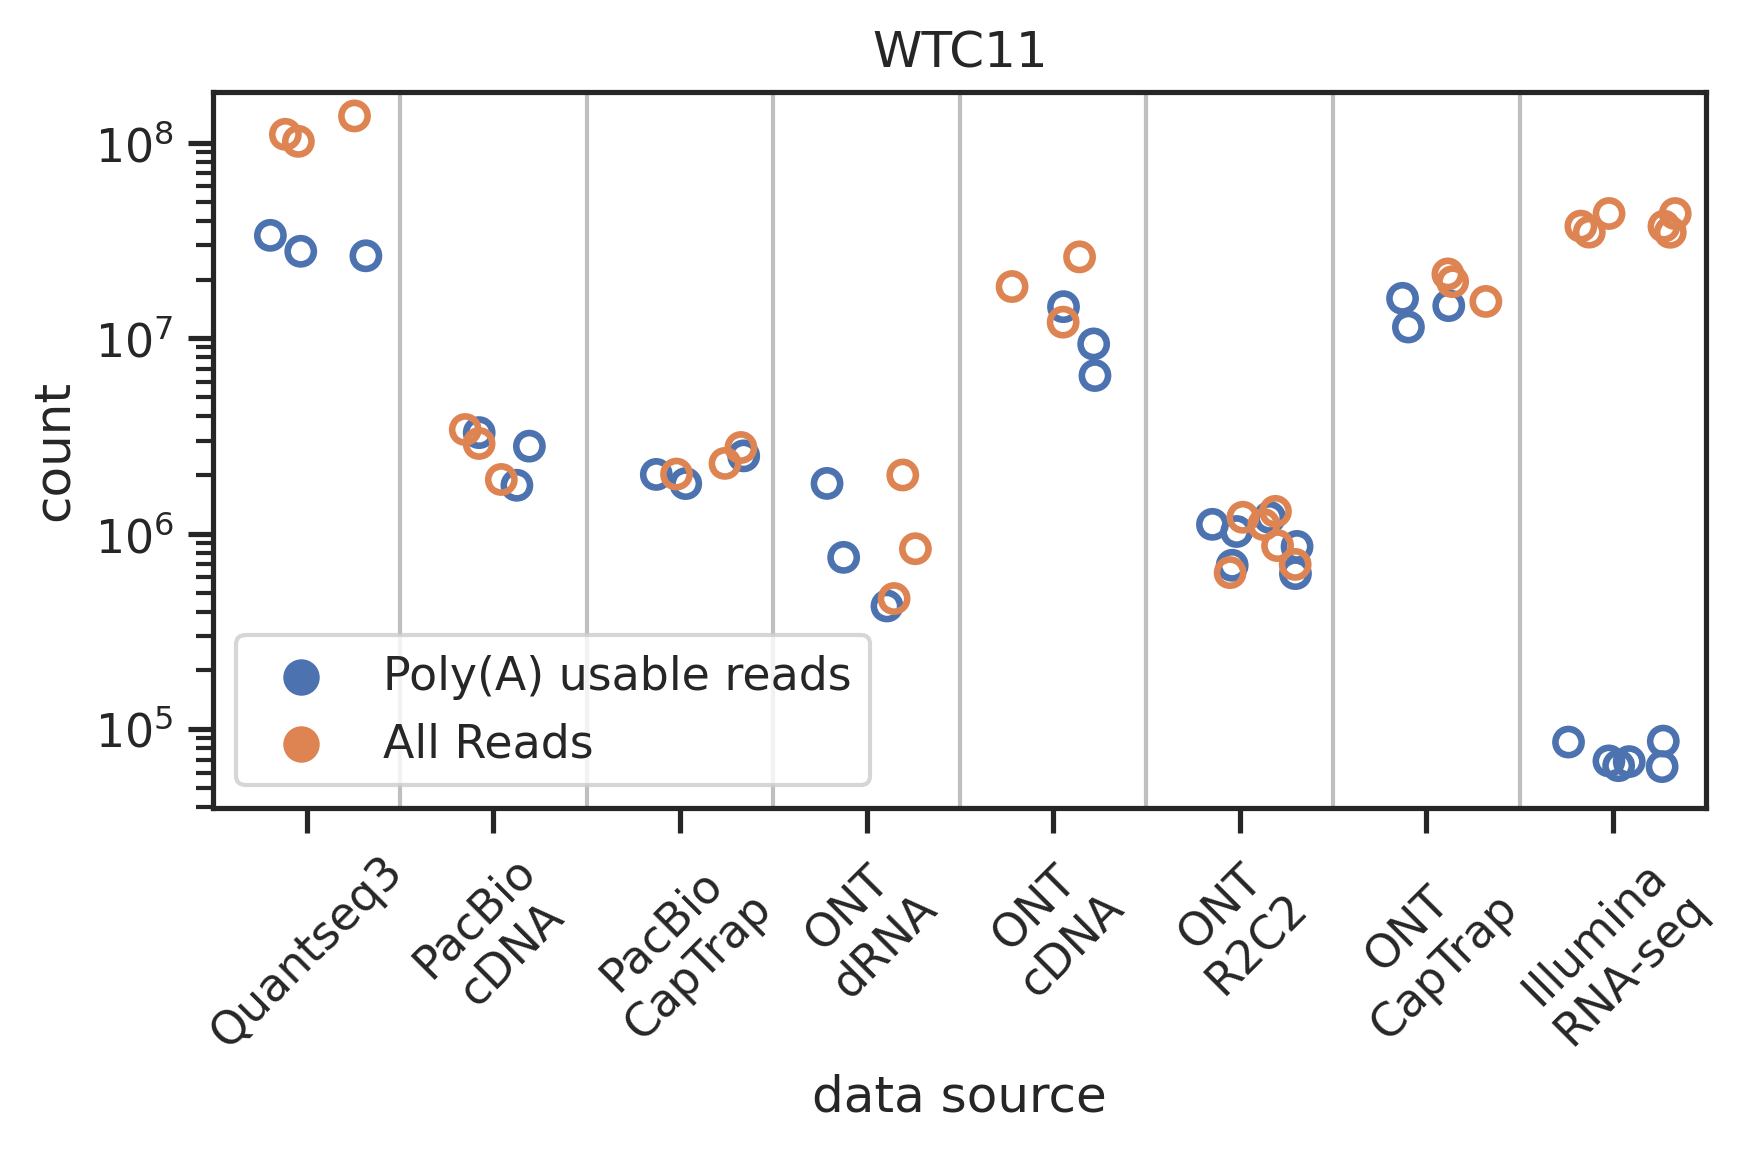

In [6]:
plt.figure(figsize=(6, 4), dpi=300)
plt.title('WTC11')
ax = sns.stripplot(x='data source', y="count", hue="read",
                   data=df, s=12, marker="$\circ$", jitter=0.3)
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='')

for i in range(len(set(df['data source'])) - 1):
    ax.axvline(i + 0.5, color='grey', lw=1, alpha=0.5)

plt.tight_layout()
plt.savefig(snakemake.output['read_nums'], bbox_inches = "tight")

In [7]:
df_counts = (
    df.groupby(['data source', 'read']).agg('mean')['count']
    .round(0).astype(int).map(lambda x: '{0:,d}'.format(x)).astype(str)
    + ' ± '
    + df.groupby(['data source', 'read']).agg('std')['count'] 
    .round(0).astype(int).map(lambda x: '{0:,d}'.format(x)).astype(str)
).reset_index()
df_counts['data source'] = df_counts['data source'].str.replace('\n', ' ')

In [8]:
df_counts

,data source,read,count
0,Illumina RNA-seq,All Reads,"34,940,279 ± 3,565,959"
1,Illumina RNA-seq,Poly(A) usable reads,"66,276 ± 9,391"
2,ONT CapTrap,All Reads,"16,967,434 ± 2,732,784"
3,ONT CapTrap,Poly(A) usable reads,"12,706,021 ± 2,141,450"
4,ONT R2C2,All Reads,"879,290 ± 252,478"
5,ONT R2C2,Poly(A) usable reads,"834,396 ± 213,929"
6,ONT cDNA,All Reads,"17,064,845 ± 6,345,987"
7,ONT cDNA,Poly(A) usable reads,"9,144,553 ± 3,696,101"
8,ONT dRNA,All Reads,"996,143 ± 722,993"
9,ONT dRNA,Poly(A) usable reads,"902,966 ± 653,236"


In [9]:
df_counts.to_csv(snakemake.output['counts'], index=False)